# Fine-tune pre-trained model with custom data

In [1]:
from fastai_old.text import *
import html
import spacy 

spacy.load('en_core_web_sm')

We're going to grab our custom style text data, e.g. the text of Alice in Wonderland, from the directory `data_style/`. This data tends to be small, so it's included in the repository. We will also create a directory in which we'll store our trained language models, `data_inf/custom_lm/`. This isn't included in the repository because it can be very large.

When we create the language model, we give it a path (in this case `data_inf/custom_lm/`). Then when we save the language model, it saves the data in `path/models/`. 

Note that we'll need to load two files to load the pre-trained data model. These should be located in `data_inf/pretrained/`. The files are `fwd_wt103.h5` and `itos_wt103.pkl`.

Finally, we'll set up a master name for this fine-tuning. The vocab and model will be saved with this name. The default here is `alice`.

In [2]:
import pandas as pd
df = pd.read_csv("data_style/popular_quotes_clean.csv")
text = df["text"].astype(str).tolist()
f = open("data_style/pop_quotes.txt", "w")
for line in text:
    f.write(line + "\n")
f.close()

In [3]:
DATA_PATH=Path('data_style/')
DATA_PATH.mkdir(exist_ok=True)

LM_PATH = Path('data_inf/custom_lm/')
LM_PATH.mkdir(exist_ok=True)

PRE_PATH=Path('data_inf/pretrained/')
PRE_PATH.mkdir(exist_ok=True)

NAME = 'pop_quotes'
ID = ''

Now we're going to load data that is a single text file of plain text. We'll need to split the text into chunks for efficient training and to hold out some data as validation. We'll set a minimum chunk size, and otherwise break at paragraphs.




In [4]:
minwords = 100

def get_texts(fname):
    texts = []
    with fname.open('r') as f:
        curr = ['', 0]
        for line in f:
            l = len(line.split(' '))
            if curr[1] + l > minwords:
                texts.append(curr[0])
                curr = [line, l]
            else:
                curr[0] += '\n' + line
                curr[1] += l
    if curr[0] != '':
        texts.append(curr[0])
    return np.array(texts)

data_file = NAME + '.txt'
all_texts = get_texts(DATA_PATH/data_file)
len(all_texts)

688

In [5]:
random.choice(all_texts)

'a mans face is his autobiography a womans face is her work of fiction\n\na mind needs books as a sword needs a whetstone if it is to keep its edge\n\na mother is the truest friend we have when trials heavy and sudden fall upon us when adversity takes the place of prosperity when friends desert us when trouble thickens around us still will she cling to us and endeavor by her kind precepts and counsels to dissipate the clouds of darkness and cause peace to return to our hearts\n'

Now we'll split the data into training and validation data. 


In [6]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    all_texts, test_size=0.3)

# trn_texts = all_texts
# val_texts = all_texts

len(trn_texts), len(val_texts)

(481, 207)

Using the pandas DataFrame speeds up pre-processing, though it does feel a little like overkill.

In [7]:
col_names = ['text']
df_trn = pd.DataFrame({'text':trn_texts}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts}, columns=col_names)

re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('.',' .').replace('?',' ?').replace('!',' !').replace('’'," '")
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
#     texts = f'\n{BOS} {FLD} 1 ' + df['text'].astype(str)
    texts = df['text'].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer(lang='en_core_web_sm').proc_all_mp(partition_by_cores(texts))
    return tok

tok_trn = get_texts(df_trn)
tok_val = get_texts(df_val)

print(len(tok_trn), len(tok_val))

' '.join(tok_trn[0])

481 207


'perhaps all the dragons in our lives are princesses who are only waiting to see us act just once with beauty and courage perhaps everything that frightens us is in its deepest essence something helpless that wants our love \n\n perhaps its impossible to wear an identity without becoming what you pretend to be \n\n perhaps one did not want to be loved so much as to be understood \n\n perhaps the greatest faculty our minds possess is the ability to cope with pain classic thinking teaches us of the four doors of the mind which everyone moves through according to their need \n'

In [8]:
freq = Counter(p for o in tok_trn for p in o)

max_vocab = 60000
min_freq = 1

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

# itos = list(set(itos).union(itos2))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

itos_file = 'itos_' + NAME + ID + '.pkl'
with open(LM_PATH/itos_file, 'wb') as f:
    pickle.dump(itos, f)

vs=len(itos)
vs

2132

In [9]:
em_sz,nh,nl = 400,1150,3

PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):                     # for word in imbd vocab
    r = stoi2[w]                                # get the int in the pretrained vocab
    new_w[i] = enc_wgts[r] if r>=0 else row_m   # add weight if in vocab, else add mean weight
    
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

wd=1e-7
bptt=70
bs=8
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(LM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.model.load_state_dict(wgts)
PRE_LM_PATH

WindowsPath('data_inf/pretrained/fwd_wt103.h5')

Now we are in language modeling black magic land, following along with the fast.ai IMDB tutorial. They say to tune the last layer for one epoch first.

In [10]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

lr = 1e-3
lrs = lr

#learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

lm_name = NAME + ID + '_lm_last_ft'
learner.save(lm_name)

And now we're going to fine-tune the whole model. First we're going to find a good learning rate, then unfreeze the whole thing (I think...) and fine-tune.



In [12]:
num_epochs = 30
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs)
lm_name = NAME + ID + '_lm_' + str(num_epochs) + 'epochs'
learner.save(lm_name)

  0%|                                                                                           | 0/79 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 1024.00 MiB total capacity; 375.96 MiB already allocated; 1.80 MiB free; 92.04 MiB cached)

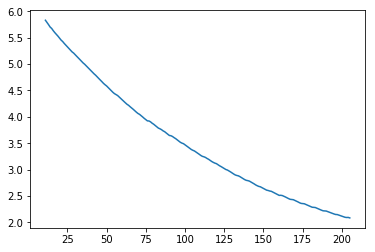

In [133]:
learner.sched.plot_loss()

In [22]:
lm_name

NameError: name 'lm_name' is not defined

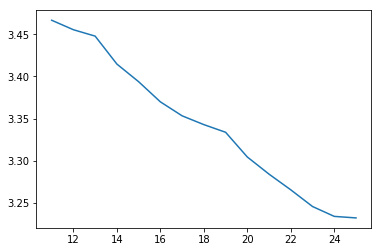

In [42]:
learner.sched.plot_loss()

In [43]:
num_epochs3 = 5
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs3)
lm_name = NAME + ID + '_lm_' + str(num_epochs + num_epochs2 + num_epochs3) + 'epochs'

epoch      trn_loss   val_loss   accuracy               
    0      2.888924   3.50002    0.298501  
    1      2.860994   3.433103   0.313989               
    2      2.748627   3.436389   0.315063               
    3      2.686392   3.442739   0.319281               
    4      2.616784   3.44484    0.318022               



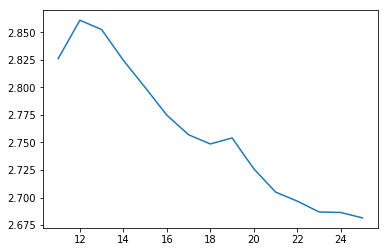

In [44]:
learner.sched.plot_loss()

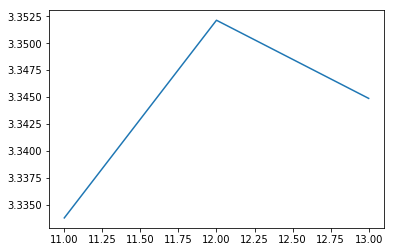

In [19]:
learner.save('alice1_lm_6epochs')
